# Etapas que componen el proyecto

## Priorización de hipótesis
En esta etapa se realizará la revisión y priorización de las hipótesis de trabajo planteadas por medio de las metodologías RICE y ICE, con el fin de seleccionar las que se consideren más relevantes y asi mismo, generar conclusiones parciales al respecto

## Análisis del Test A/B
Después de haber priorizado las hipótesis de trabajo, se procederá a cargar, corregir y explorar los datos relacionados con el Test A/B para posteriormente realizar un análisis detallado que conduzca a determinar, con base en el desempeño de los grupos, cuál es la recomendación sobre el futuro de la prueba

### Carga y preparación de datos
### Análisis

## Conclusiones generales
---------------

# Descripción de los datos
- **Tabla Hypothesis** (Tabla con calificaciones para los distintos parámetros de priorización):

    - **Hypotheses**: breves descripciones de las hipótesis
    
    - **Reach**: alcance del usuario, en una escala del uno a diez
    
    - **Impact**: impacto en los usuarios, en una escala del uno al diez
    
    - **Confidence**: confianza en la hipótesis, en una escala del uno al diez
    
    - **Effort**: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.
    

- **Tabla Orders** (Datos sobre pedidos):

    - **transactionId**: identificador de pedido

    - **visitorId**: identificador del usuario que realizó el pedido

    - **date**: fecha del pedido

    - **revenue**: ingresos del pedido

    - **group**: grupo del test A/B al que pertenece el usuario


- **Tabla Visits** (Registros del servidor con datos sobre las visitas por grupo):

    - **date**: fecha de visita

    - **group**: grupo de la prueba A/B

    - **visits**: el número de visitas en la fecha especificada en el grupo de pruebas A/B especificado
    
--------------

# 1. Priorización de hipótesis

In [1]:
# Importación de librerias

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import math

In [2]:
# Carga de datos de hipótesis

hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=";")
print(hypotheses.info())
display(hypotheses.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [3]:
# Priorización de hipótesis

hypotheses['ICE'] = round(hypotheses['Impact']*hypotheses['Confidence']/hypotheses['Effort'],2)
hypotheses['RICE'] = round(hypotheses['Impact']*hypotheses['Confidence']*hypotheses['Reach']/hypotheses['Effort'],2)

# Priorización mediante metodología ICE
ICE = hypotheses[['Hypothesis','ICE']]
display(ICE.head().sort_values(by=['ICE'], ascending = False))

# Priorización mediante metodología RICE
RICE = hypotheses[['Hypothesis','RICE']]
display(RICE.head().sort_values(by=['RICE'], ascending = False))

,Hypothesis,ICE
0,Add two new channels for attracting traffic. T...,13.33
2,Add product recommendation blocks to the store...,7.00
1,Launch your own delivery service. This will sh...,2.00
3,Change the category structure. This will incre...,1.12
4,Change the background color on the main page. ...,1.00


,Hypothesis,RICE
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
4,Change the background color on the main page. ...,3.0


Comentarios:
1. Luego de aplicar ambas metodologías de priorización, se puede observar que las hipótesis 0 a 4 se mantienen entre las 5 más relevantes
2. En comparación con las demás, las hipótesis 0 y 2 son las que se mantienen en las dos primeras posiciones de prioridad
3. Los cambios de resultados entre ambas metodologías se deben a la presencia del alcance estimado que se espera lograr con los cambios propuestos. En el caso de la hipótesis 2, el alcance esperado es de más del doble que el de la hipótesis 0, razón por la cuál se convierte en la hipótesis más relevante según la metodología RICE
------

# 2. Análisis del test A/B

# 2.1 Carga y preparación de datos

In [4]:
# Carga de datos de Ordenes

orders = pd.read_csv('/datasets/orders_us.csv')
print(orders.info())
display(orders.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A


In [5]:
# Preparación y enriquecimiento de datos de Ordenes

# Estandarización de formatos de fecha y nombre de columnas
orders['date'] = pd.to_datetime(orders['date'])
orders.columns = orders.columns.str.lower()

# Correción de grupo de asignación por usuario
corrected = orders.sort_values(by='date').groupby('visitorid')['group'].first().reset_index(name='corrected_group')
orders = orders.merge(corrected, on='visitorid')

orders.drop_duplicates(subset=['visitorid','date','revenue'], inplace=True)
orders.dropna(inplace=True)
orders.drop(columns='group', inplace=True)
orders.rename(columns={'corrected_group':'group'}, inplace=True)

print(orders.info())
display(orders.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1194 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1194 non-null   int64         
 1   visitorid      1194 non-null   int64         
 2   date           1194 non-null   datetime64[ns]
 3   revenue        1194 non-null   float64       
 4   group          1194 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 56.0+ KB
None


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,B


Comentarios:
1. Se evidenció que algunos usuarios se encontraban asignados a más de un grupo de prueba, razón por la cuál se reasignó su grupo basado en su primera fecha de compra
2. Los nombres de columnas fueron estandarizados a minúscula (lower case) para facilitar su uso durante el proyecto
3. Las fechas fueron convertidas a un formato de fecha correspondiente
4. No se encontraron datos ausentes ni duplicados en el dataset
--------

In [6]:
# Carga de datos de Visitas

visits = pd.read_csv('/datasets/visits_us.csv')
print(visits.info())
display(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [7]:
# Preparación de datos de Visitas

# Estandarización de formatos de fecha
visits['date'] = pd.to_datetime(visits['date'])

print(visits.info())
display(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Comentarios:
1. Las fechas fueron convertidas a un formato de fecha correspondiente
2. No se encontraron datos ausentes ni duplicados en el dataset
--------

In [8]:
# Unión de datasets

merged = orders.merge(visits, on=['date','group'])

merged.sort_values(by=['date','group'])

,transactionid,visitorid,date,revenue,group,visits
523,1144701458,1143609305,2019-08-01,45.3,A,719
524,1120327437,4256040402,2019-08-01,90.2,A,719
525,477940151,1422773200,2019-08-01,15.8,A,719
526,1295850747,2947100995,2019-08-01,455.8,A,719
527,1170105516,2706377257,2019-08-01,140.8,A,719
...,...,...,...,...,...,...
1093,2886170101,930758570,2019-08-31,105.7,B,718
1094,3845118557,1964413493,2019-08-31,5.5,B,718
1095,853409662,1390677121,2019-08-31,290.5,B,718
1096,4149581711,1555048873,2019-08-31,30.2,B,718


------
# 2.2 Análisis

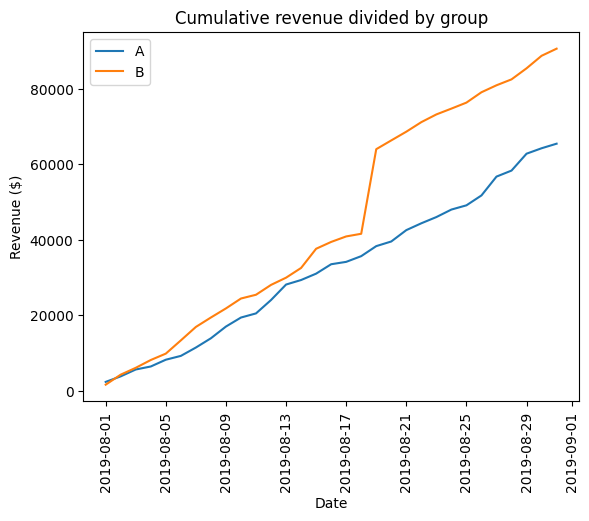

In [9]:
# Representa gráficamente el ingreso acumulado por grupo

# Lista de fechas y grupos correspondientes
grouped_dates = orders[['date','group']].drop_duplicates()

# Cálculo de ordenes acumuladas
agg_orders = (grouped_dates.apply(lambda x:
                                  orders[np.logical_and(orders['date'] <= x['date'],
                                                        orders['group'] == x['group'])].agg({'date':'max',
                                                                                             'group':'max', 
                                                                                             'transactionid':'nunique', 
                                                                                             'visitorid':'nunique',
                                                                                             'revenue':'sum'}), axis=1)).sort_values(by=['date','group'])
# Cálculo de visitantes acumulados
agg_visitors = (grouped_dates.apply(lambda x:
                                  visits[np.logical_and(visits['date'] <= x['date'],
                                                        visits['group'] == x['group'])].agg({'date':'max',
                                                                                             'group':'max', 
                                                                                             'visits':'sum'}), axis=1)).sort_values(by=['date','group'])

# Unión de dataframes de datos acumulados
cumulative = agg_orders.merge(agg_visitors, on=['date','group'])
cumulative.columns = ['date','group','order_count','customer_count','cum_revenue','cum_visits']

# Creación de dataframes discriminados por grupo
cumulativeA = cumulative.query('group == "A"')[['date','cum_revenue', 'order_count']]
cumulativeB = cumulative.query('group == "B"')[['date','cum_revenue', 'order_count']]

plt.plot(cumulativeA['date'],
         cumulativeA['cum_revenue'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['cum_revenue'], 
         label='B')

plt.title('Cumulative revenue divided by group')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Comentarios:
1. En terminos generales se aprecia que el grupo B ha presentado un mejor desempeño a lo largo de la prueba en términos de ingresos acumulados
2. Entre los días 08-17 y 08-21 se evidencia un salto importante en los ingresos medios del grupo B, por lo que se presume que existieron valores atípicos que llevaron a la métrica a comportarse de tal manera
3. Se aprecia que ambos grupos han mostrado un crecimiento constante a lo largo del tiempo

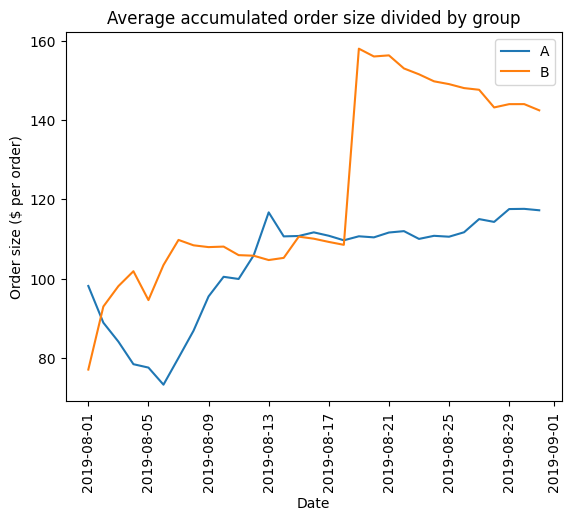

In [10]:
# Representa gráficamente el tamaño de pedido promedio acumulado por grupo

# Cálculo de tamaño de pedido promedio acumulado por grupo
cumulativeA['avg_order_size'] = cumulativeA['cum_revenue']/cumulativeA['order_count']
cumulativeB['avg_order_size'] = cumulativeB['cum_revenue']/cumulativeB['order_count']

plt.plot(cumulativeA['date'],
         cumulativeA['avg_order_size'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['avg_order_size'], 
         label='B')

plt.title('Average accumulated order size divided by group')
plt.xlabel('Date')
plt.ylabel('Order size ($ per order)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Comentarios:
1. Se puede evidenciar que el grupo B presentó efectivamente un aumento repentino en el tamaño de compras, lo cual genera algo de distorsión en los resultados
2. Se logra apreciar que a partir del día 08-13, el grupo A muestra una estabilidad en su promedio de compra que oscila entre 110 y 120 dolares por orden
3. A pesar de que el grupo B parecía comenzar a mostrar cierta estabilidad a partir del día 08-07, la presencia de valores atípicos impide llegar a una conclusión al respecto

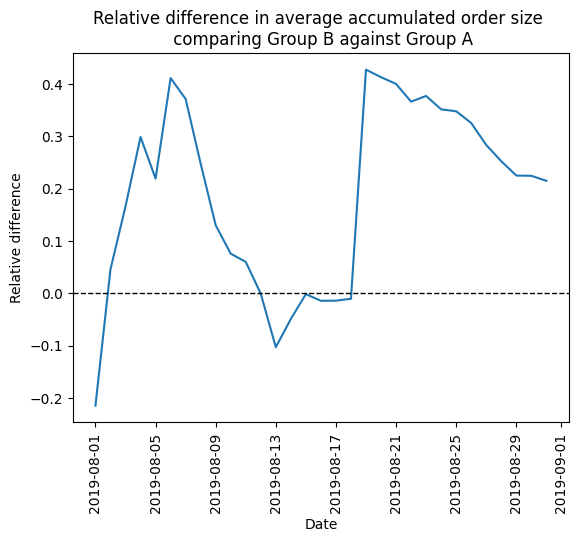

In [11]:
# Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación 
# con el grupo A

merged_cumulative = cumulativeA.merge(cumulativeB, on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative['date'],
         (merged_cumulative['avg_order_sizeB']/merged_cumulative['avg_order_sizeA'])-1)

plt.title('Relative difference in average accumulated order size \n comparing Group B against Group A')
plt.xlabel('Date')
plt.ylabel('Relative difference')
plt.axhline(y=0, linewidth=1, color='black', linestyle='--')
plt.xticks(rotation = 90)
plt.show()

Comentarios:
1. Se puede apreciar que durante los primeros 5 días de prueba, el grupo B mostró un aumento superior en el tamaño medio de sus ventas en comparación con el grupo A
2. Entre los dias 08-06 y 08-13 se evidenció una caida pronunciada en el volumen promedio del grupo A, llevandolo incluso por debajo del grupo A
3. Aunque el grupo B comenzó a mostrar debilidad luego del 08-13, no se puede llegar a ninguna conclusión debido a la distorsión generada por los datos atípicos

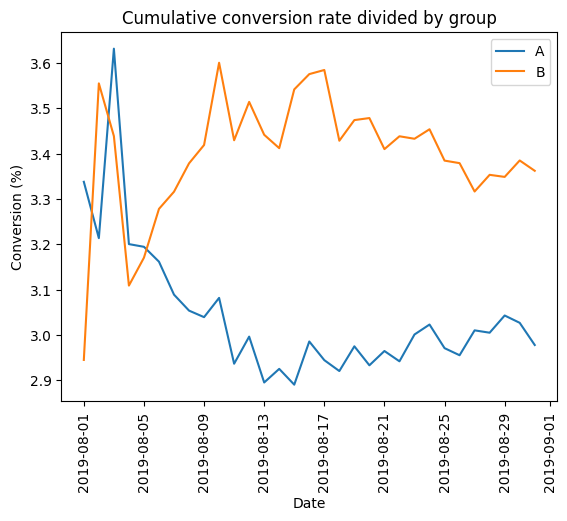

In [12]:
# Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día
# Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. 

cumulative['conversion'] = cumulative['order_count']*100/cumulative['cum_visits']

cumulativeA = cumulative.query('group == "A"')
cumulativeB = cumulative.query('group == "B"')

plt.plot(cumulativeA['date'],
         cumulativeA['conversion'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['conversion'], 
         label='B')

plt.title('Cumulative conversion rate divided by group')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Comentarios:
1. A pesar de que ambos grupos mostraron un comportamiento similar durante los primeros 5 días de prueba, a partir del 08-05 se puede evidenciar que el grupo B comenzó a mostrar un mejor desempeño, teniendo una tasa de conversión 0.5% mayor que la del grupo A
2. Una vez sean descartados los valores atípicos, se procederá a comparar nuevamente las tasas de conversión para contrastar si se produce algún cambio

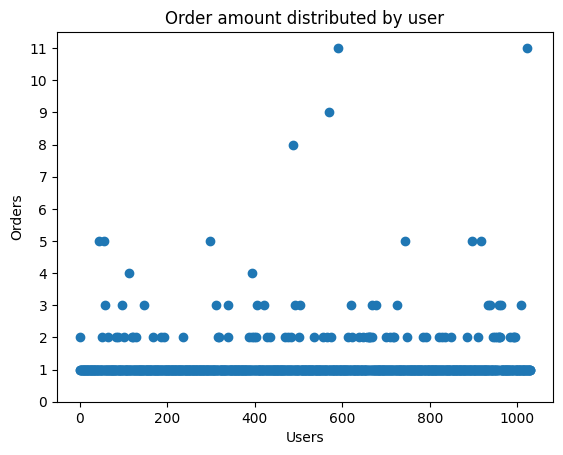

In [13]:
# Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas

grouped_orders = orders.groupby('visitorid')['transactionid'].nunique().reset_index(name='order_count')

x_values = pd.Series(range(0,len(grouped_orders)))

plt.scatter(x_values, 
            grouped_orders['order_count'])
plt.title('Order amount distributed by user')
plt.ylabel('Orders')
plt.xlabel('Users')
plt.yticks(np.arange(0, grouped_orders['order_count'].max()+1, step=1))
plt.show()

Comentarios:
1. De la distribución de ordenes se puede concluir que la mayoría realiza entre 1 y 2 compras
2. Se considera necesario un análisis de valores atípicos para definir cuales valores pueden ser descartados

In [14]:
# Calcula los percentiles 95 y 99 del número de pedidos por usuario. 
# Define el punto en el cual un punto de datos se convierte en una anomalía.

amount_anomalies = np.percentile(grouped_orders['order_count'], [90,95,99])

print(f'Límite de percentil 90: {int(amount_anomalies[0])}')
print(f'Límite de percentil 95: {int(amount_anomalies[1])}')
print(f'Límite de percentil 99: {int(amount_anomalies[2])}')

Límite de percentil 90: 1
Límite de percentil 95: 2
Límite de percentil 99: 4


Comentarios:
1. Una vez calculados los límites de los percentiles para la cantidad de ordenes, se confirma que la mayoría de usuarios no realiza más de 2 compras 
2. Se consideran valores anomalos descartables aquellos valores mayores a 2 ordenes

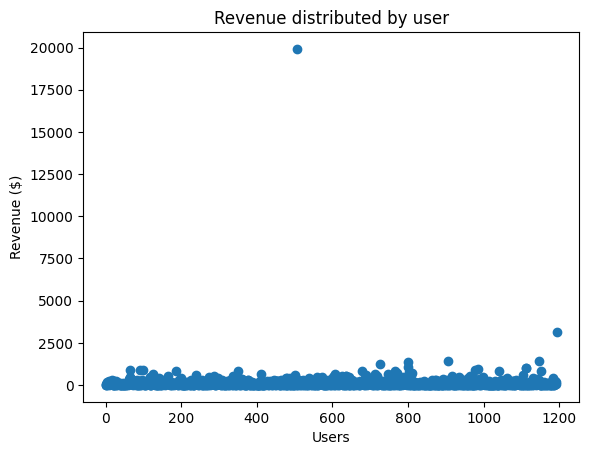

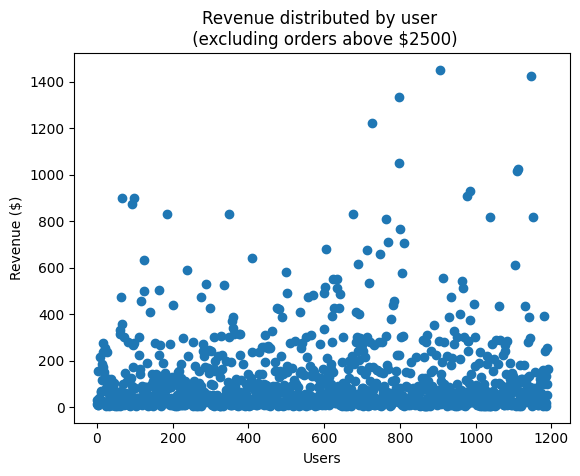

In [15]:
# Traza un gráfico de dispersión de los precios de los pedidos

# Gráfico mostrando todos los valores
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, 
            orders['revenue'])

plt.title('Revenue distributed by user')
plt.ylabel('Revenue ($)')
plt.xlabel('Users')
plt.show()

# Gráfico mostrando valores menores a $2500
x_values = pd.Series(range(0,len(orders.query('revenue < 2500')['revenue'])))

plt.scatter(x_values, 
            orders.query('revenue < 2500')['revenue'])

plt.title('Revenue distributed by user \n (excluding orders above $2500)')
plt.ylabel('Revenue ($)')
plt.xlabel('Users')
plt.show()

Comentarios:
1. De la distribución de ordenes se puede concluir que la mayoría de compras se encuentran por debajo de $400
2. Se considera necesario un análisis de valores atípicos para definir cuales valores pueden ser descartados

In [16]:
# Calcula los percentiles 95 y 99 de los precios de los pedidos. 
# Define el punto en el cual un punto de datos se convierte en una anomalía.

price_anomalies = np.percentile(orders['revenue'], [90,95,99])

print(f'Límite de percentil 90: ${int(price_anomalies[0])}')
print(f'Límite de percentil 95: ${int(price_anomalies[1])}')
print(f'Límite de percentil 99: ${int(price_anomalies[2])}')

Límite de percentil 90: $280
Límite de percentil 95: $429
Límite de percentil 99: $900


Comentarios:
1. Una vez calculados los límites de los percentiles para la cantidad de ordenes, se confirma que la mayoría de usuarios no realiza compras de más de $429 
2. Se consideran valores anomalos descartables aquellos valores mayores a 2 ordenes

In [17]:
# Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. 

# Preparación de muestra agrupada del grupo A
grouped_ordersA = (orders
                   .query('group == "A"')
                   .groupby('visitorid')['transactionid']
                   .nunique()
                   .reset_index(name='order_count'))

sampleA = pd.concat([grouped_ordersA['order_count'], 
                    pd.Series(0, 
                              index=np.arange(visits.query('group == "A"')['visits'].sum()
                                              - len(grouped_ordersA['order_count'])), name='orders')], axis=0)

# Preparación de muestra agrupada del grupo B
grouped_ordersB = (orders
                   .query('group == "B"')
                   .groupby('visitorid')['transactionid']
                   .nunique()
                   .reset_index(name='order_count'))

sampleB = pd.concat([grouped_ordersB['order_count'], 
                    pd.Series(0, 
                              index=np.arange(visits.query('group == "B"')['visits'].sum()
                                              - len(grouped_ordersB['order_count'])), name='orders')], axis=0)

# Cálculo de significación estadística 
alpha = 0.05

print(f'alpha: {alpha:.3f} ({alpha*100:.2f}%)')
print(f'Valor p: {st.mannwhitneyu(sampleB,sampleA)[1]:.3f} ({st.mannwhitneyu(sampleB,sampleA)[1]*100:.2f}%)')
print(f'Diferencia relativa de conversión del grupo B respecto al grupo A: {((sampleB.mean()/sampleA.mean())-1):.3f} ({((sampleB.mean()/sampleA.mean())-1)*100:.2f}%)')
print()

if st.mannwhitneyu(sampleB,sampleA)[1] < alpha:
    print('Hipótesis nula rechazada: El comportamiento de las muestras indica que existe una diferencia significativa en la conversión entre los grupos A y B')
else:
    print('Hipótesis nula aceptada: El comportamiento de las muestras indica que no  existe una diferencia significativa en la conversión entre los grupos A y B')

alpha: 0.050 (5.00%)
Valor p: 0.010 (0.97%)
Diferencia relativa de conversión del grupo B respecto al grupo A: 0.129 (12.89%)

Hipótesis nula rechazada: El comportamiento de las muestras indica que existe una diferencia significativa en la conversión entre los grupos A y B


In [18]:
# Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto

grouped_revenueA = orders.query('group == "A"')['revenue']
grouped_revenueB = orders.query('group == "B"')['revenue']

print(f'alpha: {alpha:.3f} ({alpha*100:.2f}%)')
print(f'Valor p: {st.mannwhitneyu(grouped_revenueB, grouped_revenueA)[1]:.3f} ({st.mannwhitneyu(grouped_revenueB, grouped_revenueA)[1]*100:.2f}%)')
print(f'Diferencia relativa en número de pedidos del grupo B respecto al grupo A: {((grouped_revenueB.mean()/grouped_revenueA.mean())-1):.3f} ({((grouped_revenueB.mean()/grouped_revenueA.mean())-1)*100:.2f}%)')
print()

if st.mannwhitneyu(grouped_revenueB, grouped_revenueA)[1] < alpha:
    print('Hipótesis nula rechazada: El comportamiento de las muestras indica que existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B')
else:
    print('Hipótesis nula aceptada: El comportamiento de las muestras indica que no existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B')

alpha: 0.050 (5.00%)
Valor p: 0.627 (62.66%)
Diferencia relativa en número de pedidos del grupo B respecto al grupo A: 0.215 (21.47%)

Hipótesis nula aceptada: El comportamiento de las muestras indica que no existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B


In [19]:
# Cálculo de usuarios anomalos

excessive_orders = pd.concat([grouped_ordersA.query('order_count > @amount_anomalies[1]')['visitorid'], 
                              grouped_ordersB.query('order_count > @amount_anomalies[1]')['visitorid']], axis=0)

expensive_orders = orders.query('revenue > @price_anomalies[1]')['visitorid']

abnormal_users = pd.concat([expensive_orders, excessive_orders], axis=0).drop_duplicates().sort_values()

print(f'Cantidad de usuarios que presentaron anomalías en el volumen o precio de pedido: {abnormal_users.shape[0]}')

Cantidad de usuarios que presentaron anomalías en el volumen o precio de pedido: 84


In [20]:
# Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados

# Preparación de muestra agrupada del grupo A
filtered_sampleA = pd.concat([grouped_ordersA[~grouped_ordersA['visitorid'].isin(abnormal_users)]['order_count'], 
                              pd.Series(0, 
                                        index=np.arange(visits.query('group == "A"')['visits'].sum()
                                                        - len(grouped_ordersA['order_count'])), name='orders')], axis=0)

# Preparación de muestra agrupada del grupo B
filtered_sampleB = pd.concat([grouped_ordersB[~grouped_ordersB['visitorid'].isin(abnormal_users)]['order_count'], 
                              pd.Series(0, 
                                        index=np.arange(visits.query('group == "B"')['visits'].sum()
                                                        - len(grouped_ordersB['order_count'])), name='orders')], axis=0)

# Cálculo de significación estadística 
alpha = 0.05

print(f'alpha: {alpha:.3f} ({alpha*100:.2f}%)')
print(f'Valor p: {st.mannwhitneyu(filtered_sampleB,filtered_sampleA)[1]:.3f} ({st.mannwhitneyu(filtered_sampleB,filtered_sampleA)[1]*100:.2f}%)')
print(f'Diferencia relativa de conversión del grupo B respecto al grupo A: {((filtered_sampleB.mean()/filtered_sampleA.mean())-1):.3f} ({((filtered_sampleB.mean()/filtered_sampleA.mean())-1)*100:.2f}%)')
print()

if st.mannwhitneyu(filtered_sampleB,filtered_sampleA)[1] < alpha:
    print('Hipótesis nula rechazada: El comportamiento de las muestras excluyendo los valores atípicos indica que existe una diferencia significativa en la conversión entre los grupos A y B')
else:
    print('Hipótesis nula aceptada: El comportamiento de las muestras excluyendo los valores atípicos indica que no  existe una diferencia significativa en la conversión entre los grupos A y B')




alpha: 0.050 (5.00%)
Valor p: 0.010 (0.97%)
Diferencia relativa de conversión del grupo B respecto al grupo A: 0.181 (18.10%)

Hipótesis nula rechazada: El comportamiento de las muestras excluyendo los valores atípicos indica que existe una diferencia significativa en la conversión entre los grupos A y B


In [21]:
# Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados

filtered_revenueA = orders[(orders['group'] == 'A') & ~(orders['visitorid'].isin(abnormal_users))]['revenue']
filtered_revenueB = orders[(orders['group'] == 'B') & ~(orders['visitorid'].isin(abnormal_users))]['revenue']

print(f'alpha: {alpha:.3f} ({alpha*100:.2f}%)')
print(f'Valor p: {st.mannwhitneyu(filtered_revenueB, filtered_revenueA)[1]:.3f} ({st.mannwhitneyu(filtered_revenueB, filtered_revenueA)[1]*100:.2f}%)')
print(f'Diferencia relativa en número de pedidos del grupo B respecto al grupo A: {((filtered_revenueB.mean()/filtered_revenueA.mean())-1):.3f} ({((filtered_revenueB.mean()/filtered_revenueA.mean())-1)*100:.2f}%)')
print()

if st.mannwhitneyu(filtered_revenueB, filtered_revenueA)[1] < alpha:
    print('Hipótesis nula rechazada: El comportamiento de las muestras excluyendo los valores atípicos indica que existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B')
else:
    print('Hipótesis nula aceptada: El comportamiento de las muestras excluyendo los valores atípicos indica que no existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B')

alpha: 0.050 (5.00%)
Valor p: 0.343 (34.32%)
Diferencia relativa en número de pedidos del grupo B respecto al grupo A: -0.070 (-6.98%)

Hipótesis nula aceptada: El comportamiento de las muestras excluyendo los valores atípicos indica que no existe una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B


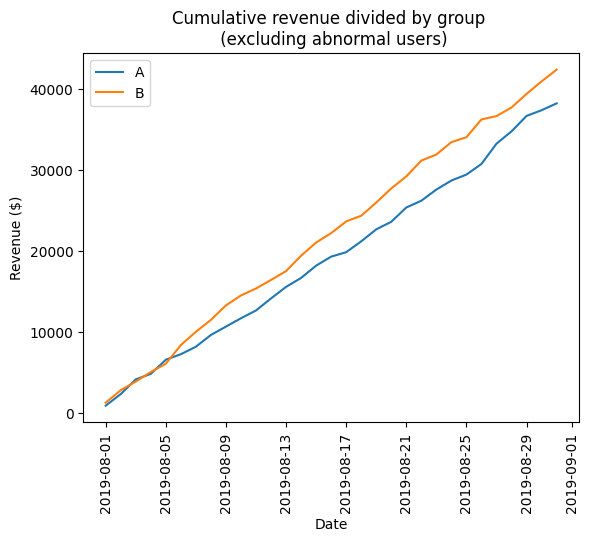

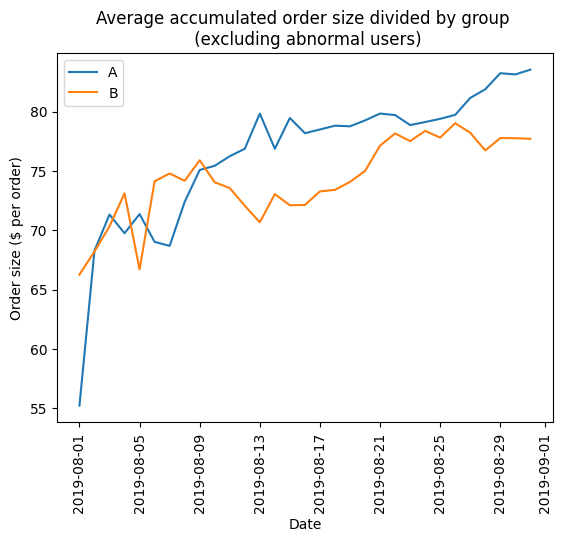

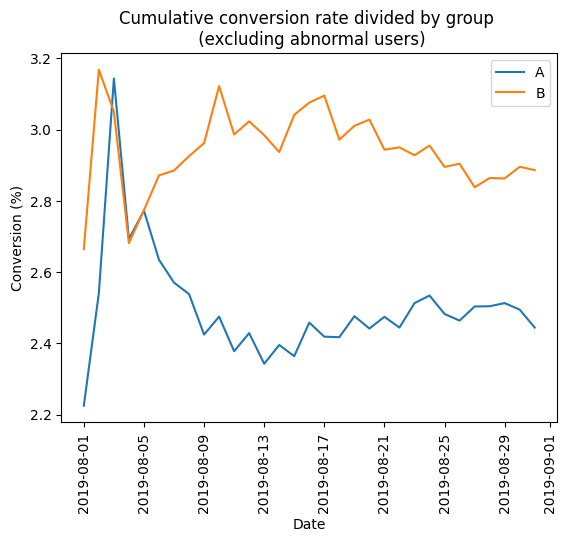

In [22]:
# Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 

filtered_orders = orders[~(orders['visitorid'].isin(abnormal_users))]

# Cálculo de ordenes acumuladas
agg_orders = (grouped_dates.apply(lambda x:
                                  filtered_orders[np.logical_and(filtered_orders['date'] <= x['date'],
                                                                 filtered_orders['group'] == x['group'])].agg({'date':'max',
                                                                                                     'group':'max', 
                                                                                                     'transactionid':'nunique', 
                                                                                                     'visitorid':'nunique',
                                                                                                     'revenue':'sum'}), axis=1)).sort_values(by=['date','group'])
# Cálculo de visitantes acumulados
agg_visitors = (grouped_dates.apply(lambda x:
                                  visits[np.logical_and(visits['date'] <= x['date'],
                                                        visits['group'] == x['group'])].agg({'date':'max',
                                                                                             'group':'max', 
                                                                                             'visits':'sum'}), axis=1)).sort_values(by=['date','group'])

# Unión de dataframes de datos acumulados
cumulative = agg_orders.merge(agg_visitors, on=['date','group'])
cumulative.columns = ['date','group','order_count','customer_count','cum_revenue','cum_visits']

# Creación de dataframes discriminados por grupo
cumulativeA = cumulative.query('group == "A"')[['date','cum_revenue', 'order_count']]
cumulativeB = cumulative.query('group == "B"')[['date','cum_revenue', 'order_count']]

plt.plot(cumulativeA['date'],
         cumulativeA['cum_revenue'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['cum_revenue'], 
         label='B')

plt.title('Cumulative revenue divided by group \n (excluding abnormal users)')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Cálculo de tamaño de pedido promedio acumulado por grupo
cumulativeA['avg_order_size'] = cumulativeA['cum_revenue']/cumulativeA['order_count']
cumulativeB['avg_order_size'] = cumulativeB['cum_revenue']/cumulativeB['order_count']

plt.plot(cumulativeA['date'],
         cumulativeA['avg_order_size'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['avg_order_size'], 
         label='B')

plt.title('Average accumulated order size divided by group \n (excluding abnormal users)')
plt.xlabel('Date')
plt.ylabel('Order size ($ per order)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Tasa de conversión acumulada
cumulative['conversion'] = cumulative['order_count']*100/cumulative['cum_visits']

cumulativeA = cumulative.query('group == "A"')
cumulativeB = cumulative.query('group == "B"')

plt.plot(cumulativeA['date'],
         cumulativeA['conversion'],
         label='A')

plt.plot(cumulativeB['date'],
         cumulativeB['conversion'], 
         label='B')

plt.title('Cumulative conversion rate divided by group \n (excluding abnormal users)')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

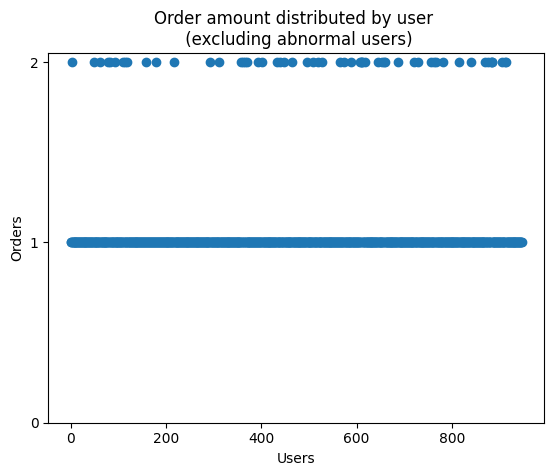

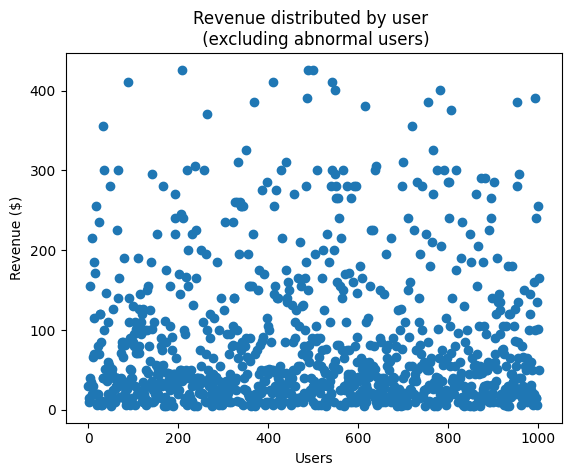

In [23]:
# Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas
grouped_orders = filtered_orders.groupby('visitorid')['transactionid'].nunique().reset_index(name='order_count')

x_values = pd.Series(range(0,len(grouped_orders)))

plt.scatter(x_values, 
            grouped_orders['order_count'])
plt.title('Order amount distributed by user \n (excluding abnormal users)')
plt.ylabel('Orders')
plt.xlabel('Users')
plt.yticks(np.arange(0, grouped_orders['order_count'].max()+1, step=1))
plt.show()

# Gráfico mostrando todos los valores
x_values = pd.Series(range(0,len(filtered_orders['revenue'])))

plt.scatter(x_values, 
            filtered_orders['revenue'])

plt.title('Revenue distributed by user \n (excluding abnormal users)')
plt.ylabel('Revenue ($)')
plt.xlabel('Users')
plt.show()

------------
# 3. Conclusiones Generales

Tras revisar el comportamiento de los grupos A y B, se puede concluir que:
1. Los datos procesados y sin procesar revelan que la conversión de ambos grupos es significativamente distinta. Esto puede comprobarse a través de las gráficas de conversión, donde se evidencia en ambos escenarios que el grupo B presenta una tasa de conversión 0.5% mayor que la del grupo A en la mayoría de días
2. Luego de procesar los datos se evidenció que la diferencia relativa de coversión del grupo B resepcto al A aumentó aproximadamente 6%, pasando de 12.89% a 18.10% 
3. Los datos procesados y sin procesar demostraron que no existe una diferencia significativa en el tamaño medio de pedidos
4. La gráfica procesada de ingresos acumulados demuestra que el grupo B ha mantenido un registro de ingresos superior al del grupo A durante todo el periodo del experimento
5. Con base en lo mencionado anteriormente, se recomienda detener el experimento pues se considera que el grupo B ha mostrado un mejor comportamiento a nivel de ingresos y tasa de conversión promedio incluso cuando el promedio de compras diarias suele ser similar o igual al del grupo A 